In [1]:
# import
import pandas as pd
import numpy as np
import glob
import warnings
warnings.filterwarnings('ignore')
#import matplotlib.pyplot as plt
import itertools
import numpy as np
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
# Machine Learning libraries.
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

In [7]:
leftTurn = pd.read_excel("leftturn.xlsx")
data = leftTurn.drop(["File_id","time_of_entering","time_of_exiting","precipitatingEvent","preIncidentManeuver","crashStatus", "crash", "maneuverJudgment", "incomplete_video", "vehicle_movement"], axis = 1)

In [8]:
filledData = data.where(pd.notna(data), data.mean(), axis='columns')
filledData = (filledData - filledData.mean())/filledData.std()
y = leftTurn["crashStatus"]
y[y=="Balanced-Sample Baseline"] = False
y[y != False] = True
y  = np.asarray(y,dtype=np.float64)
print("Number of crashs events: ", sum(y))
print("Class Balance with Crash and no Crash: ", sum(y)/len(y))
# from sklearn.feature_selection import SelectKBest,f_classif
# selector = SelectKBest(f_classif, k=10).fit(filledData,y)
# featurefilledData = selector.transform(filledData)
X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.8)

Number of crashs events:  140.0
Class Balance with Crash and no Crash:  0.509090909091


In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    


def Classifier_performance(clf, target_names, y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, title="confusion matrix"):
    # Fitting the training data
    clf.fit(X_train, y_train)
    
    # Predicting the data
    y_pred = clf.predict(X_test)
    Y_train_pred = clf.predict(X_train)
    
    # Printing the accuracies and confusion matrix
    print("Training Accuracy Score: ", accuracy_score(Y_train_pred , y_train))
    print("validation Accuracy Score:", accuracy_score(y_pred, y_test))
    print("Classification Report: ")
    print(classification_report(y_test, y_pred, target_names=target_names))
    cm = confusion_matrix(y_test, y_pred)
    # Plot normalized confusion matrix
    #plt.figure()
    plot_confusion_matrix(cm, classes=target_names, normalize=False,
                          title=title)

    plt.show()
    plt.close()
    
    # Showing the lower dimension data projection using PCA
    pca = PCA(n_components=2)
    
    # Fitting and transformed the data
    filledData_lower = pca.fit_transform(filledData)
    y = pd.Series(y)
    filledData_lower = pd.DataFrame(filledData_lower)
    filledData_lower['labels'] = y.values
    
    # Creating the figure
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15) # X Axis
    ax.set_ylabel('Principal Component 2', fontsize = 15) # Y Axis
    ax.set_title('2 component PCA', fontsize = 20) # Title
    crash = filledData_lower[filledData_lower["labels"] == 1]
    no_crash = filledData_lower[filledData_lower["labels"] == 0]
    ax.plot(crash[0], crash[1], "*", label=target_names[0])
    ax.plot(no_crash[0], no_crash[1], "o", label=target_names[1])
    plt.legend()
    plt.show()
    plt.close()

# Predicting Crash risk of all the drivers using oridinary least square penality

Training Accuracy Score:  0.718181818182
validation Accuracy Score: 0.745454545455
Classification Report: 
             precision    recall  f1-score   support

   No_crash       0.69      0.85      0.76        26
      Crash       0.83      0.66      0.73        29

avg / total       0.76      0.75      0.74        55

Confusion matrix, without normalization
[[22  4]
 [10 19]]


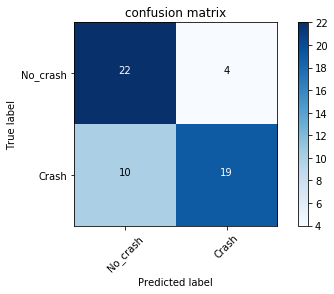

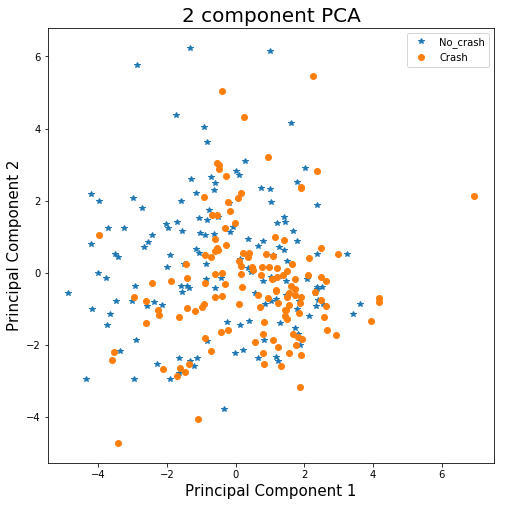

In [10]:
clf = LogisticRegression(max_iter=1000, penalty='l1')
Classifier_performance(clf, ["No_crash", "Crash"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [11]:
est = sm.OLS(y, filledData.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     1.768
Date:                Thu, 21 Jun 2018   Prob (F-statistic):             0.0158
Time:                        22:22:24   Log-Likelihood:                -275.00
No. Observations:                 275   AIC:                             600.0
Df Residuals:                     250   BIC:                             690.4
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Time_day                -0.0562 

# Performing Analysis for older driver prediction

In [12]:
filledData = data.where(pd.notna(data), data.mean(), axis='columns')
filledData = filledData.drop(["age"], axis =1)
filledData = (filledData - filledData.mean())/filledData.std()
y = leftTurn["age"]
y[y >= 65] = True
y[y != True] = False
y  = np.asarray(y,dtype=np.float64)
print("Number of old drivers: ", sum(y))
print("Class Balance with old drivers and young driver: ", sum(y)/len(y))

Number of old drivers:  172.0
Class Balance with old drivers and young driver:  0.625454545455


Training Accuracy Score:  0.713541666667
validation Accuracy Score: 0.506024096386
Classification Report: 
             precision    recall  f1-score   support

        Old       0.29      0.11      0.16        35
      Young       0.55      0.79      0.65        48

avg / total       0.44      0.51      0.44        83

Confusion matrix, without normalization
[[ 4 31]
 [10 38]]


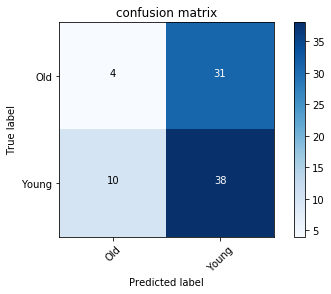

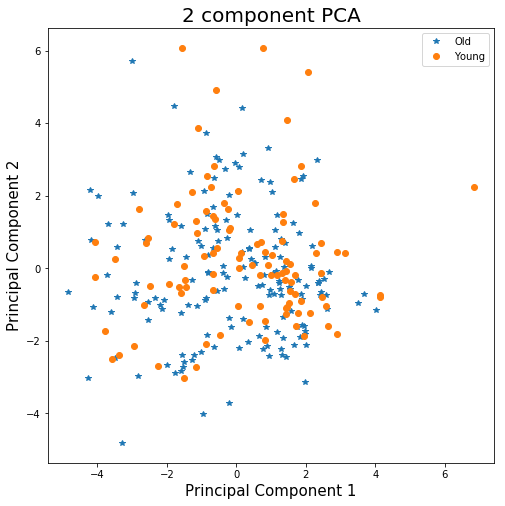

In [13]:
X_train, X_test, y_train, y_test = train_test_split(filledData, y, train_size=0.7)
clf = LogisticRegression(max_iter=1000, penalty='l1')
Classifier_performance(clf, ["Old", "Young"], y, filledData=filledData, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test )

In [14]:
est = sm.OLS(y, filledData.astype(float))
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                 -0.048
Method:                 Least Squares   F-statistic:                    0.4750
Date:                Thu, 21 Jun 2018   Prob (F-statistic):              0.984
Time:                        22:22:44   Log-Likelihood:                -319.57
No. Observations:                 275   AIC:                             687.1
Df Residuals:                     251   BIC:                             774.0
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Time_day                -0.0024 